In [69]:
import pennylane as qml
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCN
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import scatter
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
ds = TUDataset("/tmp/PROTEINS2", "PROTEINS")
ds.num_features, ds.num_classes, len(ds)

Extracting /tmp/PROTEINS2/PROTEINS/PROTEINS.zip
Processing...
Done!


(3, 2, 1113)

In [177]:
ds = ds.shuffle()
break1 = int(len(ds) * 0.8)
break2 = int(len(ds) * 0.9)
training_data = ds[:break1]
validation_data = ds[break1:break2]
test_data = ds[break2:]
training_loader = DataLoader(training_data, batch_size=2048, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [198]:
def build_qfe_circuit(dev, n_qubits, n_layers):
    @qml.qnode(dev, interface="torch") #, diff_method="parameter-shift")
    def qfe_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return qml.probs(wires=range(n_qubits)) #qml.state() #[qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    return qml.qnn.TorchLayer(qfe_circuit, weight_shapes)

class QFE(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.wires = in_features
        self.dev = qml.device("default.qubit", wires=self.wires)
        self.qfe = build_qfe_circuit(self.dev, self.wires, 2)
    
    def forward(self, x):
        return self.qfe(x)

In [199]:
class QFE_GCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # self.qfe = QFE(in_features)
        # self.lin = torch.nn.Linear(in_features, 2**in_features)

        self.gcn = GCN(
            in_channels=in_features,
            hidden_channels=64,
            num_layers=4,
            dropout = 0.1,
            out_channels=out_features
        )
    
    def forward(self, data):
        x = data.x
        # x = self.lin(x)
        # x = self.qfe(x.to(device="cpu")).to(device=x.device)

        x = self.gcn(x, data.edge_index, batch=data.batch)
        
        # x = global_mean_pool(x, data.batch)
        x = scatter(x, data.batch, dim=0, reduce="mean")
        x = F.log_softmax(x, dim=1)

        # out = torch.zeros(data.num_graphs, 2, device=x.device)

        # for i in range(data.num_graphs):
        #     out[i] = x[data.batch == i].mean(dim=0)
        
        # out = F.log_softmax(out, dim=1)
        # x = out
        
        return x

In [195]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QFE_GCN(3, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

losses = []

model.train()
for epoch in tqdm(range(60)):
    epoch_losses = []
    for batch in training_loader:
        optimizer.zero_grad()
        out = model(batch.to(device))
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        epoch_losses.append(loss.detach().cpu())
        optimizer.step()
    losses.append(epoch_losses)

100%|██████████| 60/60 [00:02<00:00, 20.83it/s]


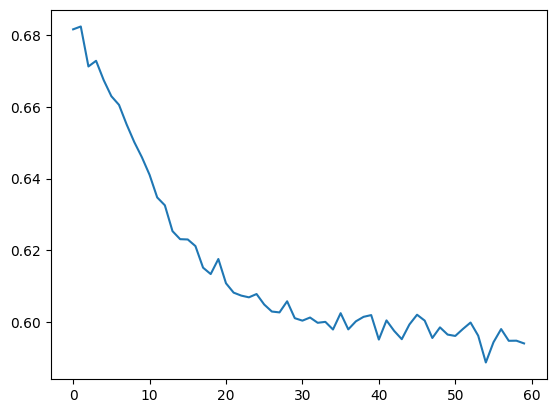

In [196]:
avg_losses = [np.mean(losses[i]) for i in range(len(losses))]
plt.plot(avg_losses)

In [197]:
model.eval()
correct = 0
total = 0
for batch in test_loader:
    out = model(batch.to(device))
    print(out.argmax(dim=1)) 
    print(batch.y)
    print()
    correct += sum(out.argmax(dim=1) == batch.y)
    total += len(batch.y)
print(f"Accuracy: {correct/total}")

tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')

Accuracy: 0.7767857313156128
